In [1]:
import Bio

Bio.__version__

'1.84'

In [2]:
import skbio

skbio.__version__

'0.6.2'

In [3]:
import biotite

biotite.__version__

'1.0.1'

In [4]:
import anjl

anjl.__version__

'1.0.0'

In [5]:
import numpy as np

np.__version__

'2.0.2'

In [6]:
import numba

numba.__version__

'0.60.0'

In [7]:
import zarr
from scipy.spatial.distance import squareform
import time
import pandas as pd
import functools

In [8]:
xxl = zarr.load("xxl/dist.zarr.zip")
xxl_D = squareform(xxl)
xxl_D.shape

(8825, 8825)

In [9]:
def sample_data(D, size, seed):
    np.random.seed(seed)
    indices = np.random.choice(D.shape[0], size=size, replace=False)
    return D.take(indices, axis=0).take(indices, axis=1)

In [25]:
@functools.cache
def bench_anjl_rapid(size, seed):
    print(size, seed)
    D = sample_data(xxl_D, size=size, seed=seed)
    before = time.time()
    anjl.rapid_nj(D)
    after = time.time()
    duration = after - before
    return duration

In [27]:
bench_anjl_rapid(200, seed=1)

0.007709503173828125

In [28]:
@functools.cache
def bench_anjl_canonical(size, seed):
    print(size, seed)
    D = sample_data(xxl_D, size=size, seed=seed)
    before = time.time()
    anjl.canonical_nj(D)
    after = time.time()
    duration = after - before
    return duration

In [30]:
bench_anjl_canonical(200, seed=1)

0.004141330718994141

In [31]:
from biotite.sequence.phylo import neighbor_joining as biotite_nj


@functools.cache
def bench_biotite(size, seed):
    print(size, seed)
    D = sample_data(xxl_D, size=size, seed=seed)
    before = time.time()
    biotite_nj(D)
    after = time.time()
    duration = after - before
    return duration

In [32]:
bench_biotite(200, seed=1)

200 1


0.012845516204833984

In [33]:
@functools.cache
def bench_skbio(size, seed):
    print(size, seed)
    D = sample_data(xxl_D, size=size, seed=seed)
    dm = skbio.DistanceMatrix(D)
    before = time.time()
    skbio.tree.nj(dm)
    after = time.time()
    duration = after - before
    return duration

In [34]:
bench_skbio(200, seed=1)

200 1


0.1536557674407959

In [35]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix


@functools.cache
def bench_biopython(size, seed):
    print(size, seed)
    D = sample_data(xxl_D, size=size, seed=seed)
    dl = [[float(D[i, j]) for j in range(i + 1)] for i in range(D.shape[0])]
    dm = DistanceMatrix(names=[str(i) for i in range(D.shape[0])], matrix=dl)
    constructor = DistanceTreeConstructor()
    before = time.time()
    constructor.nj(dm)
    after = time.time()
    duration = after - before
    return duration

In [36]:
bench_biopython(200, seed=1)

200 1


3.256747245788574

In [159]:
def run_benchmark(name, f, sizes, reps, cutoff=30):
    results = []
    abort = False
    for size in sizes:
        if abort:
            break
        for rep in range(reps):
            if abort:
                break
            duration = f(size=size, seed=rep)
            if duration > cutoff:
                abort = True
            results.append([name, size, rep, duration])
    df = pd.DataFrame.from_records(
        results, columns=["implementation", "size", "rep", "time"]
    )
    return df

In [160]:
df_biopython = run_benchmark(
    name="BioPython",
    f=bench_biopython,
    sizes=[50, 100, 150, 200, 300, 400, 500],
    cutoff=100,
    reps=3,
)
df_biopython

,implementation,size,rep,time
0,BioPython,50,0,0.083560
1,BioPython,50,1,0.060253
2,BioPython,50,2,0.060644
3,BioPython,100,0,0.443854
4,BioPython,100,1,0.415457
5,BioPython,100,2,0.411590
6,BioPython,150,0,1.380568
7,BioPython,150,1,1.359871
8,BioPython,150,2,1.353179
9,BioPython,200,0,3.322348


In [161]:
df_skbio = run_benchmark(
    name="scikit-bio",
    f=bench_skbio,
    sizes=[50, 100, 150] + list(range(200, 2200, 200)),
    reps=3,
    cutoff=100,
)
df_skbio

,implementation,size,rep,time
0,scikit-bio,50,0,0.041680
1,scikit-bio,50,1,0.051028
2,scikit-bio,50,2,0.016162
3,scikit-bio,100,0,0.149352
4,scikit-bio,100,1,0.307049
5,scikit-bio,100,2,0.288162
6,scikit-bio,150,0,0.149396
7,scikit-bio,150,1,0.353079
8,scikit-bio,150,2,0.140435
9,scikit-bio,200,0,0.222226


In [162]:
df_biotite = run_benchmark(
    name="biotite",
    f=bench_biotite,
    sizes=[50, 100, 150] + list(range(200, 3200, 200)),
    reps=3,
    cutoff=100,
)
df_biotite

,implementation,size,rep,time
0,biotite,50,0,0.001581
1,biotite,50,1,0.000872
2,biotite,50,2,0.000564
3,biotite,100,0,0.002476
4,biotite,100,1,0.002355
5,biotite,100,2,0.002254
6,biotite,150,0,0.006171
7,biotite,150,1,0.005539
8,biotite,150,2,0.006190
9,biotite,200,0,0.013107


In [163]:
df_anjl_canonical = run_benchmark(
    name="anjl.canonical_nj",
    f=bench_anjl_canonical,
    sizes=[50, 100, 150] + list(range(200, 3000, 200)) + list(range(3000, 6000, 500)),
    reps=3,
    cutoff=100,
)
df_anjl_canonical

,implementation,size,rep,time
0,anjl.canonical_nj,50,0,0.000853
1,anjl.canonical_nj,50,1,0.000166
2,anjl.canonical_nj,50,2,0.000147
3,anjl.canonical_nj,100,0,0.000535
4,anjl.canonical_nj,100,1,0.000529
...,...,...,...,...
64,anjl.canonical_nj,5000,1,47.803516
65,anjl.canonical_nj,5000,2,48.696107
66,anjl.canonical_nj,5500,0,66.508343
67,anjl.canonical_nj,5500,1,68.774081


In [164]:
df_anjl_rapid = run_benchmark(
    name="anjl.rapid_nj",
    f=bench_anjl_rapid,
    sizes=[50, 100, 150] + list(range(200, 3000, 200)) + list(range(3000, 9000, 500)),
    reps=3,
    cutoff=100,
)
df_anjl_rapid

,implementation,size,rep,time
0,anjl.rapid_nj,50,0,0.000977
1,anjl.rapid_nj,50,1,0.000690
2,anjl.rapid_nj,50,2,0.000733
3,anjl.rapid_nj,100,0,0.002107
4,anjl.rapid_nj,100,1,0.002284
...,...,...,...,...
82,anjl.rapid_nj,8000,1,58.074711
83,anjl.rapid_nj,8000,2,49.088682
84,anjl.rapid_nj,8500,0,62.453770
85,anjl.rapid_nj,8500,1,69.281142


In [165]:
df_results = pd.concat(
    [
        df_biopython,
        df_skbio,
        df_biotite,
        df_anjl_canonical,
        df_anjl_rapid,
    ],
    axis=0,
)
df_results

,implementation,size,rep,time
0,BioPython,50,0,0.083560
1,BioPython,50,1,0.060253
2,BioPython,50,2,0.060644
3,BioPython,100,0,0.443854
4,BioPython,100,1,0.415457
...,...,...,...,...
82,anjl.rapid_nj,8000,1,58.074711
83,anjl.rapid_nj,8000,2,49.088682
84,anjl.rapid_nj,8500,0,62.453770
85,anjl.rapid_nj,8500,1,69.281142


In [166]:
df_results.to_csv("results.csv")

In [167]:
import plotly.express as px

In [168]:
df_plot = (
    df_results.groupby(["implementation", "size"])
    .agg(
        time_mean=("time", "mean"),
        time_std=("time", "std"),
    )
    .reset_index()
)
df_plot

,implementation,size,time_mean,time_std
0,BioPython,50,0.068153,0.013345
1,BioPython,100,0.423633,0.017618
2,BioPython,150,1.364539,0.014279
3,BioPython,200,3.309717,0.021049
4,BioPython,300,11.333002,0.550450
...,...,...,...,...
85,scikit-bio,1200,12.021412,0.456461
86,scikit-bio,1400,19.193505,0.955617
87,scikit-bio,1600,26.680464,0.255991
88,scikit-bio,1800,40.109836,0.895637


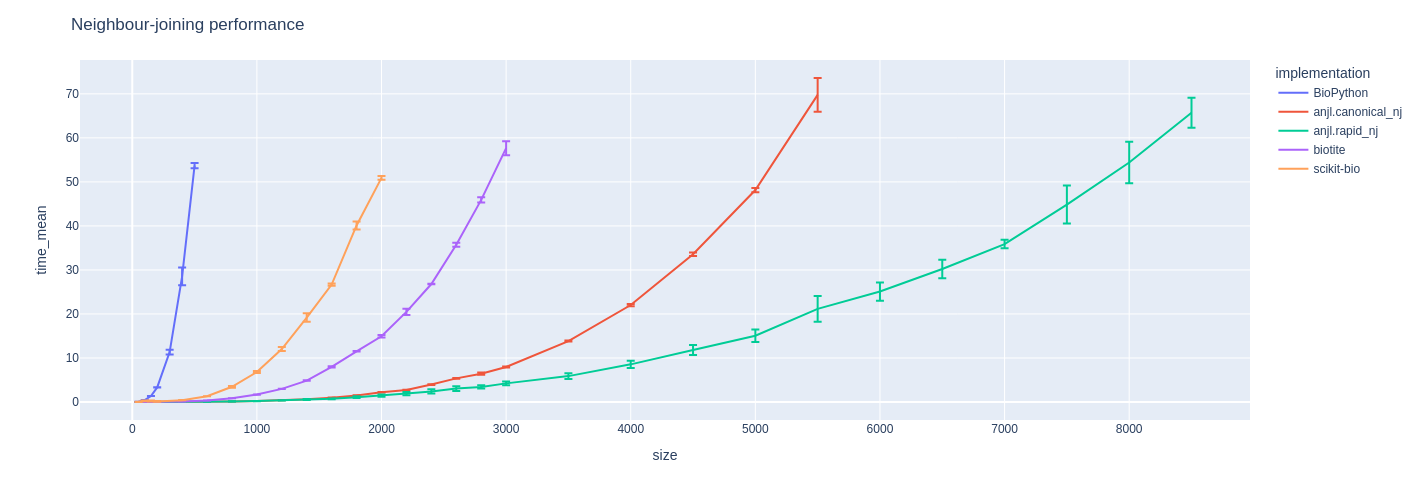

In [169]:
fig = px.line(
    df_plot,
    x="size",
    y="time_mean",
    error_y="time_std",
    width=800,
    height=500,
    color="implementation",
    # log_y=True,
    # log_x=True,
)
fig.update_layout(
    title="Neighbour-joining performance",
)